# D4G | LGA CRATer | Construire un indicateur de "distance moyenne aux commerces" pour un territoire

* **Auteurs** : Valentine Lambolez (@valentinel) & Thomas Cayla ([@thocayla](https://github.com/thocayla))

* **Date de dernière mise à jour** : 24/06/2021

* **Lien Framagit du projet** : [ici](https://framagit.org/lga/crater-data-exploration/-/issues/4)

* **Objectif** : Mettre au point et tester une méthodologie de calcul pour un indicateur de résilience du maillon Distribution/Consommation, permettant de définir le niveau de dépendance à la voiture (et donc entre autres aux énergies fossiles) pour l’achat alimentaire des habitants d’une commune en évaluant la distance moyenne/médiane à un commerce alimentaire (ou le nombre de commerces alimentaires par km2)

* **Approche proposée** :
    * 1- Utiliser la base permanente des équipements pour identifier la liste des commerces et les géolocaliser sur le territoire francais
    * 2- Utiliser les données de population de l'INSEE, en particulier les carroyages à 1km2  (population pour chaque carreau de 1km par 1km sur le territoire francais, tester également avec 200m)
    * 3- Calcul de plusieurs indicateurs :
        * 1- Le nombre de commerces par habitant par territoire (carroyage / iris / commune / département / région) & découpage en 3 catégories -> petit / moyen / grand commerce alimentaire
        * 2- La densité de commerces alimentaires par territoire (carroyage / iris / commune / département / région) & découpage en 3 catégories -> petit / moyen / grand commerce alimentaire
        * 3- La distance moyenne à un commerce alimentaire par carroyage
        * 4- Le nombre d'habitants à moins (ou plus) de X km d'un commerce par carroyage

* **Sources de données** :
    * [BPE au format csv (2019)](https://www.insee.fr/fr/statistiques/3568638?sommaire=3568656)
    * [Carroyage INSEE au format shp (2015)](https://www.insee.fr/fr/statistiques/4176293?sommaire=4176305)

### Table des matières

* [0- Load libraries](#chapter0)
* [1- Import data](#chapter1)
    * [Lecture base BPE](#section_1_1)
    * [Lecture des données de carroyage](#section_1_2)
    * [Intersection des 2 datasets](#section_1_3)
* [2- Calcul des indicateurs & visualisation des données](#chapter2)
    * [2.1 Nombre de commerces par carroyage / iris / commune / département / région](#section_2_1)
    * [2.2 Densité de commerces par habitant au carroyage / iris / commune / département / région](#section_2_2)
    * [2.3 Calcul de la distance moyenne aux commerces](#section_2_3)
    * [2.4 Calcul du nombre d'habitants à moins (ou plus) de X km d'un commerce](#section_2_4)

## 0- Load libraries <a class="anchor" id="chapter0"></a>

In [1]:
## Installer un nouvel environnement conda (plus simple pour installer geopandas avec les bonnes dépendances)
#conda create -n geo_env
#conda activate geo_env
#conda config --env --add channels conda-forge
#conda config --env --set channel_priority strict
#conda install python=3 geopandas

In [2]:
import pandas as pd
import numpy as np
from shapely.geometry import Point 
import geopandas as gpd
import matplotlib.pyplot as plt

## 1- Import data <a class="anchor" id="chapter1"></a>

* **Lecture base BPE** <a class="anchor" id="section_1_1"></a>

In [3]:
filename = "bpe19_ensemble_xy.csv"
data_bpe = pd.read_csv(filename, sep=";")
print(data_bpe.shape)
data_bpe.head(1)

C:\Users\thoca\Anaconda3\envs\geo_env\lib\site-packages\IPython\core\interactiveshell.py:3169: DtypeWarning: Columns (1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(2607293, 9)


REG DEP DEPCOM      DCIRIS    AN TYPEQU  LAMBERT_X  LAMBERT_Y  \
0   84  01  01451  01451_0000  2019   D107        NaN        NaN   

        QUALITE_XY  
0  Non géolocalisé

In [4]:
## Types de commerces
# DCIRIS : Département, commune et IRIS d’implantation de l’équipement
# TYPEQU : Prendre tous lles commerces alimentaires
#B101 - Hypermarché, B102 - Supermarché, B201 - Supérette, B202 - Épicerie, 
#B203 - Boulangerie, B204 - Boucherie charcuterie, 
#B205 - Produits surgelés, B206 - Poissonnerie
list_alimentation = ['B101','B102','B201','B202','B203','B204','B205','B206']
data_bpe_alimentaire = data_bpe[data_bpe.TYPEQU.isin(list_alimentation)]
data_bpe_alimentaire = data_bpe_alimentaire[data_bpe_alimentaire.QUALITE_XY != 'Non géolocalisé'].reset_index(drop=True)
data_bpe_alimentaire['isCommerceAlimentaire'] = 1 # création d'une variable binaire pour vérifier qu'il s'agit bien d'un commerce alimentaire
print("Nombre de communes avec au moins un commerce alimentaire : {}".format(len(set(data_bpe_alimentaire.DEPCOM))))

Nombre de communes avec au moins un commerce alimentaire : 15880


In [5]:
data_bpe_vide = data_bpe[~data_bpe.DEPCOM.isin(data_bpe_alimentaire.DEPCOM)]
data_bpe_vide = data_bpe_vide[data_bpe_vide.QUALITE_XY.isin(['Bonne','Acceptable','Mauvaise'])].reset_index(drop=True)
print("Nombre de communes sans commerce alimentaire : {}".format(len(set(data_bpe_vide.DEPCOM))))
## Sélectionner une seule ligne par territoire avec un commerce nonalimentaire
data_bpe_vide = data_bpe_vide.sample(frac=1).groupby(['REG','DEP','DEPCOM','DCIRIS'],sort=False).head(1)
data_bpe_vide['isCommerceAlimentaire'] = 0

Nombre de communes sans commerce alimentaire : 22747


In [6]:
## Renommage des variables
data_bpe_alimentaire = data_bpe_alimentaire.rename(columns={'REG': 'id_region', 'DEP': 'id_departement', 
                                                            'DEPCOM': 'id_commune','DCIRIS': 'id_iris',
                                                            'AN': 'annee', 'TYPEQU': 'code_equipement_bpe', 
                                                            'LAMBERT_Y':'coordonnee_y', 'LAMBERT_X': 'coordonnee_x', 
                                                            'QUALITE_XY': 'qualite_geolocalisation'})

data_bpe_vide = data_bpe_vide.rename(columns={'REG': 'id_region', 'DEP': 'id_departement', 
                                            'DEPCOM': 'id_commune','DCIRIS': 'id_iris',
                                            'AN': 'annee', 'TYPEQU': 'code_equipement_bpe', 
                                            'LAMBERT_Y':'coordonnee_y', 'LAMBERT_X': 'coordonnee_x', 
                                            'QUALITE_XY': 'qualite_geolocalisation'})

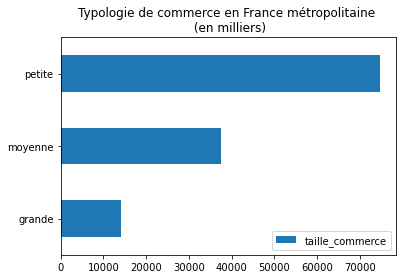

In [7]:
## Création d'une variable typologie de commerce
data_bpe_alimentaire['taille_commerce'] = 'petite'
#B101 - Hypermarché, B102 - Supermarché
data_bpe_alimentaire.loc[data_bpe_alimentaire['code_equipement_bpe'].isin(['B101','B102']),'taille_commerce'] = 'grande'  
#B201 - Supérette, B202 - Épicerie, B205 - Produits surgelés
data_bpe_alimentaire.loc[data_bpe_alimentaire['code_equipement_bpe'].isin(['B201','B202','B205']),'taille_commerce'] = 'moyenne' 

data_bpe_alimentaire.taille_commerce.value_counts().sort_values().plot(kind='barh',
                                                           title='Typologie de commerce en France métropolitaine \n (en milliers)')
plt.legend(loc='best')
plt.show()

**Transformation des données en dataframe géolocalisé (geopandas)**

In [8]:
## Concatenation des tables d'abord (territoires avec commerces alimentaires vs reste)
print(data_bpe_alimentaire.shape, data_bpe_vide.shape)
data_bpe_concat = pd.concat([data_bpe_alimentaire, data_bpe_vide], axis=0)
print(data_bpe_concat.shape)

(126386, 11) (28876, 10)
(155262, 11)


In [9]:
geometry = [Point(xy) for xy in zip(data_bpe_concat['coordonnee_x'], data_bpe_concat['coordonnee_y'])]
crs = {'init': 'epsg:2154'} # Coordinate reference system : Lambert (norme française)
# Creating a Geographic data frame 
data_bpe_concat = gpd.GeoDataFrame(data_bpe_concat, crs=crs, geometry=geometry)
print(data_bpe_concat.shape)
data_bpe_concat.head(1)

C:\Users\thoca\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


(155262, 12)


id_region id_departement id_commune     id_iris  annee code_equipement_bpe  \
0         52             44      44055  44055_0101   2019                B203   

   coordonnee_x  coordonnee_y qualite_geolocalisation  isCommerceAlimentaire  \
0      294438.5     6700464.2                   Bonne                      1   

  taille_commerce                        geometry  
0          petite  POINT (294438.500 6700464.200)

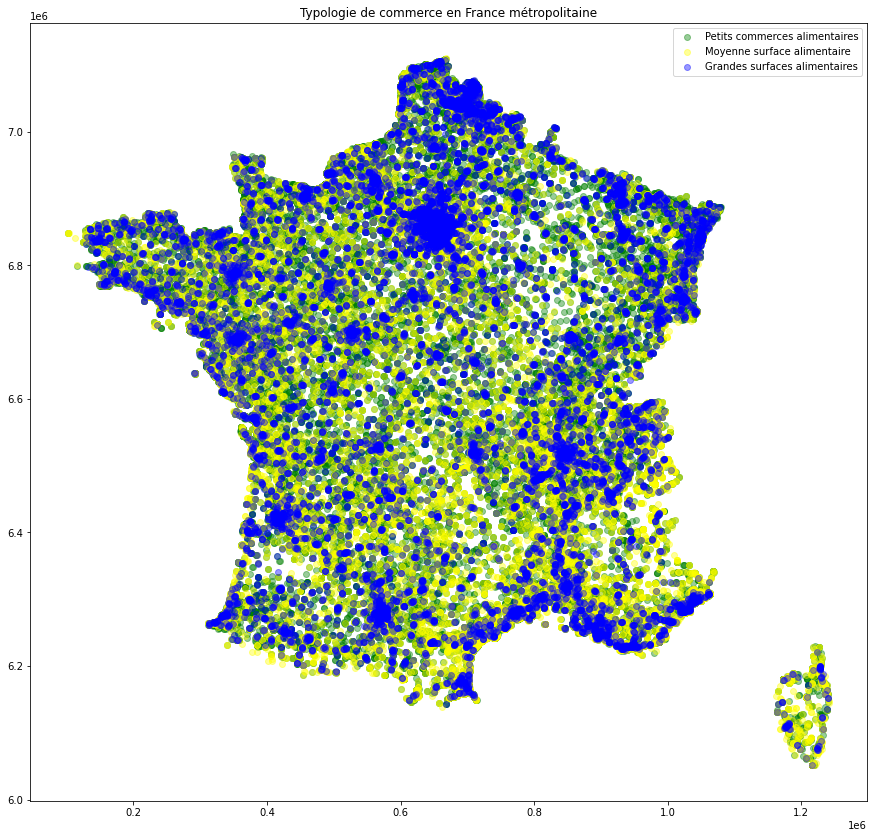

In [10]:
alpha = 0.4
figsize = (15, 15)
fig, ax = plt.subplots(figsize=figsize)
# filtre sur les commerces alimentaires
temp = data_bpe_concat[data_bpe_concat.isCommerceAlimentaire==1].copy() 
## Lamber 93 : coordonnées France métropolitaine (https://geofree.fr/gf/projguess.asp)
x_min = 0
x_max = 1300000
y_min = 6000000
y_max = 7200000
temp = temp[(temp.coordonnee_x>=x_min) & (temp.coordonnee_x<=x_max) & (temp.coordonnee_y>=y_min) & (temp.coordonnee_y<=y_max)]
temp[temp.taille_commerce=='petite'].geometry.plot(ax=ax, alpha=alpha, color="green", label='Petits commerces alimentaires')
temp[temp.taille_commerce=='moyenne'].geometry.plot(ax=ax, alpha=alpha, color="yellow", label='Moyenne surface alimentaire')
temp[temp.taille_commerce=='grande'].geometry.plot(ax=ax, alpha=alpha, color="blue", label='Grandes surfaces alimentaires')
plt.title('Typologie de commerce en France métropolitaine')
plt.legend(loc='best')
plt.show()

* **Lecture des données de carroyage** <a class="anchor" id="section_1_2"></a>

In [11]:
%%time

filename = "Filosofi2015_carreaux_1000m_shp/Filosofi2015_carreaux_1000m_metropole.shp"
data_insee = gpd.read_file(filename)
print(data_insee.shape)
data_insee = data_insee[['Id_carr1km','geometry','Ind']]
data_insee.head(1)

(374944, 32)
Wall time: 27.8 s


Id_carr1km  \
0  CRS3035RES1000mN2030000E4252000   

                                            geometry  Ind  
0  POLYGON ((1217949.529 6049793.871, 1217860.808...  6.0

* **Intersection des 2 datasets** <a class="anchor" id="section_1_3"></a>

In [12]:
%%time

pointsInPolygon = gpd.sjoin(data_bpe_concat, data_insee, how='inner', op='intersects')
pointsInPolygon = pointsInPolygon.reset_index(drop=True)
print(pointsInPolygon.shape)
pointsInPolygon.head(1)

(148615, 15)
Wall time: 33.8 s


id_region id_departement id_commune     id_iris  annee code_equipement_bpe  \
0         52             44      44055  44055_0101   2019                B203   

   coordonnee_x  coordonnee_y qualite_geolocalisation  isCommerceAlimentaire  \
0      294438.5     6700464.2                   Bonne                      1   

  taille_commerce                        geometry  index_right  \
0          petite  POINT (294438.500 6700464.200)       241250   

                        Id_carr1km     Ind  
0  CRS3035RES1000mN2763000E3389000  1575.0

## 2- Calcul des indicateurs & visualisation des données <a class="anchor" id="chapter2"></a>

In [13]:
list_var = ['id_region','id_departement','id_commune','id_iris','Id_carr1km']
#list_var = ['id_region']
top = 10
kind = 'barh'

* **2.1 Nombre de commerces par carroyage / iris / commune / département / région** <a class="anchor" id="section_2_1"></a>

Nombre de commerces par id_region
Nombre de id_region avec commerce alimentaire=13


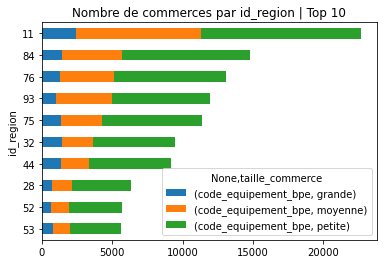


Nombre de commerces par id_departement
Nombre de id_departement avec commerce alimentaire=96


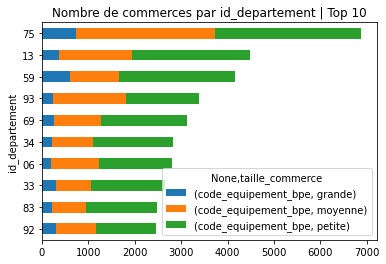


Nombre de commerces par id_commune
Nombre de id_commune avec commerce alimentaire=15751



Nombre de commerces par id_iris
Nombre de id_iris avec commerce alimentaire=27352


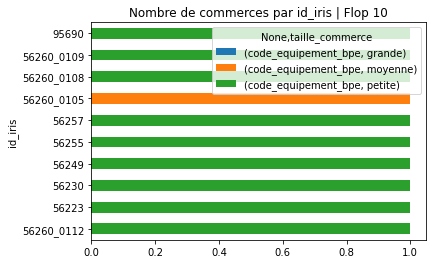


Nombre de commerces par Id_carr1km
Nombre de Id_carr1km avec commerce alimentaire=33671


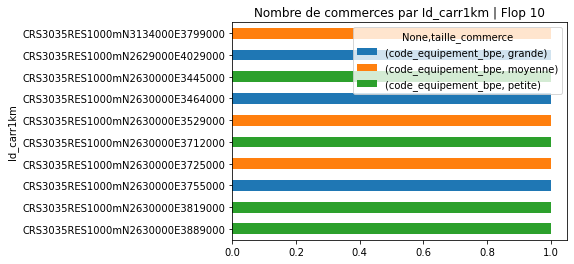

In [14]:
## Nombre de commerces par km carré, iris, commune, département, région
stacked = True
for var in list_var:
    print('Nombre de commerces par {}'.format(var))
    temp = pointsInPolygon[[var,'code_equipement_bpe','taille_commerce']].groupby([var,'taille_commerce']).count()
    temp = temp.unstack()
    print('Nombre de {} avec commerce alimentaire={}'.format(var,temp.shape[0]))
    cols = list(temp.columns)
    temp['total'] = np.sum(temp,axis=1)
    #display(temp.sort_values(by='total', ascending=True)[cols].head(top))
    temp.sort_values(by='total', ascending=True)[cols].tail(top).plot(kind=kind, stacked=stacked,
                                                                       title='Nombre de commerces par {} | Top {}'.format(var,top))
    plt.show()
    temp.sort_values(by='total', ascending=False)[cols].tail(top).plot(kind=kind, stacked=stacked,
                                                                        title='Nombre de commerces par {} | Flop {}'.format(var,top))
    plt.show()
    print("\n", "=" * 100)

* **2.2 Densité de commerces par habitant au carroyage / iris / commune / département / région** <a class="anchor" id="section_2_2"></a>

Densité de commerces par id_region
Nombre de id_region avec commerce alimentaire=13


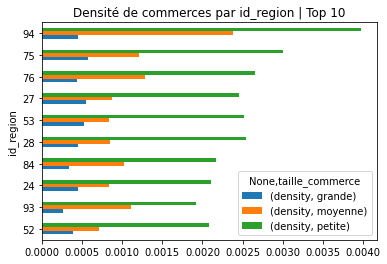


Densité de commerces par id_departement
Nombre de id_departement avec commerce alimentaire=96


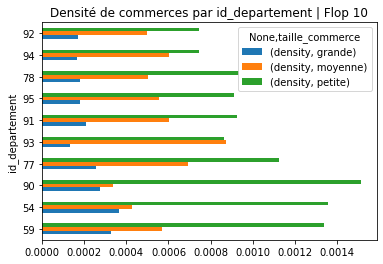


Densité de commerces par id_commune
Nombre de id_commune avec commerce alimentaire=15751


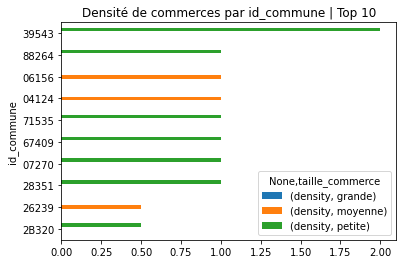


Densité de commerces par id_iris
Nombre de id_iris avec commerce alimentaire=27352


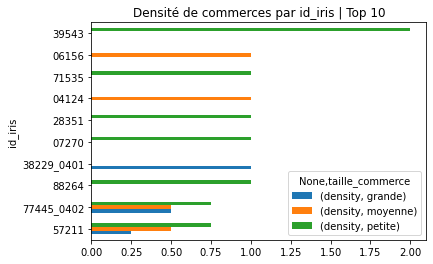

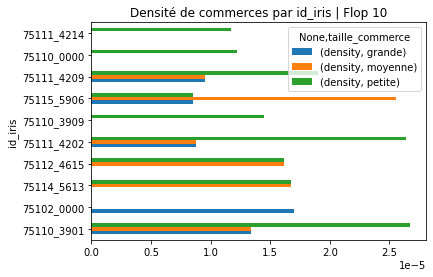


Densité de commerces par Id_carr1km
Nombre de Id_carr1km avec commerce alimentaire=33671


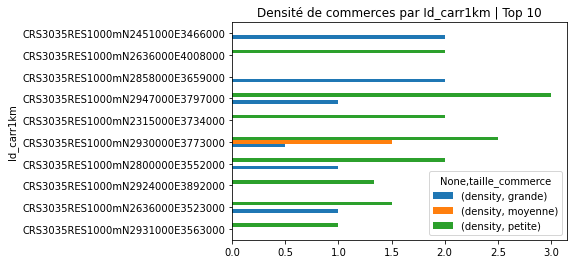

In [15]:
## Densité de commerces par habitant km carré, iris, commune, département, région
nb_individus = {} # nb individus par commune (pour éviter les doublons)
stacked = False

for var in list_var:
    print('Densité de commerces par {}'.format(var))
    nb_individus[var] = pointsInPolygon[[var,'Ind']].drop_duplicates().groupby(var).sum()
    temp = pointsInPolygon[[var,'code_equipement_bpe','taille_commerce']].groupby([var,'taille_commerce']).count()
    temp['Ind'] = nb_individus[var].loc[temp.index.get_level_values(var)].values
    temp['density'] = temp.code_equipement_bpe/temp.Ind
    temp.drop(['code_equipement_bpe', 'Ind'], axis=1, inplace=True)
    temp = temp.unstack()
    print('Nombre de {} avec commerce alimentaire={}'.format(var,temp.shape[0]))
    cols = list(temp.columns)
    temp['total'] = np.mean(temp,axis=1)
    temp.sort_values(by='total', ascending=True)[cols].tail(top).plot(kind=kind, stacked=stacked,
                                                                       title='Densité de commerces par {} | Top {}'.format(var,top))
    plt.show()
    temp.sort_values(by='total', ascending=False)[cols].tail(top).plot(kind=kind, stacked=stacked,
                                                                        title='Densité de commerces par {} | Flop {}'.format(var,top))
    plt.show()
    print("\n", "=" * 100)

* **2.3 Calcul de la distance moyenne aux commerces** <a class="anchor" id="section_2_3"></a>

In [16]:
%%time

## Calcul du centroide de chaque carroyage
tmp = [data_insee.loc[pointsInPolygon.index_right[i]].geometry.centroid for i in range(pointsInPolygon.shape[0])]
pointsInPolygon['polygonCentroid'] = gpd.GeoSeries(tmp, crs=crs)

Wall time: 25.2 s


C:\Users\thoca\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [17]:
%%time

## On choisit un département
dep = '85' # Vendée
temp = pointsInPolygon[pointsInPolygon.id_departement==dep]
reg = temp.id_region.unique()[0]

# 1- geoloc des commerces alimentaires dans ce département
geoloc_commerces = temp[temp.isCommerceAlimentaire==1]['geometry']

# 2- On récupère tous les centroides uniques des carreaux de la région du département (Pays de le Loire)
geoloc_centroids = gpd.GeoSeries(pointsInPolygon[pointsInPolygon.id_region==reg]['polygonCentroid'].unique(), crs=crs)

# 3- On calcule de toutes les distances entre les centroides des carreaux de la région
# les commerces du département et on récupère la distance minimale par centroide
print('{} centroides x {} commerces à calculer :'.format(len(geoloc_centroids),len(geoloc_commerces)))
all_dist = geoloc_centroids.apply(lambda g: geoloc_commerces.distance(g))
all_dist = pd.DataFrame(all_dist)
print(all_dist.shape)
all_dist['polygonCentroid'] = geoloc_centroids # pour la jointure finale d'après
all_dist['min_distance'] = all_dist.min(axis=1)
all_dist = all_dist[['polygonCentroid','min_distance']]
display(all_dist.head())

# 4- Distance moyenne aux commerces dans la région
jointure_finale = pd.merge(temp, all_dist, how='left', on='polygonCentroid')
print('Distance moyenne aux commerces dans le département {} = {} mètres'.format(dep,np.round(np.mean(jointure_finale['min_distance']),2)))

C:\Users\thoca\Anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


2588 centroides x 1225 commerces à calculer :
(2588, 1225)


polygonCentroid  min_distance
0  POINT (294468.720 6700713.793)  29274.701160
1  POINT (291479.595 6700416.847)  29469.283975
2  POINT (292382.181 6701508.430)  30363.848270
3  POINT (303810.682 6697633.407)  26372.016491
4  POINT (316070.812 6716885.624)  47783.321508

Distance moyenne aux commerces dans le département 85 = 428.52 mètres
Wall time: 26.4 s


In [18]:
jointure_finale['min_distance'].describe()

count    1282.000000
mean      428.521043
std       635.999898
min        10.406206
25%       196.995503
50%       307.539791
75%       442.556862
max      5883.475508
Name: min_distance, dtype: float64

q1=96.79946273398114 q2=307.5397910381589 q3=540.6616295782603


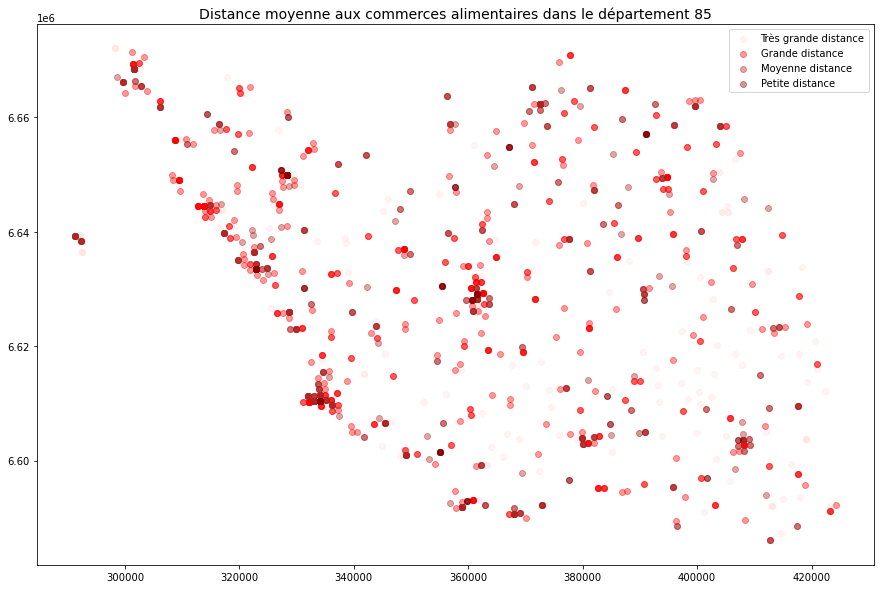

Wall time: 371 ms


In [21]:
%%time

## Cartographie par distance moyenne aux commerces
# Découpage en quantile
q1 = jointure_finale['min_distance'].quantile(q=0.1)
q2 = jointure_finale['min_distance'].quantile(q=0.5)
q3 = jointure_finale['min_distance'].quantile(q=0.9)
print('q1={}'.format(q1), 'q2={}'.format(q2), 'q3={}'.format(q3))

# Carte de France
fig, ax = plt.subplots(figsize=figsize)
jointure_finale[jointure_finale['min_distance']>q3].polygonCentroid.plot(ax=ax, alpha=alpha, color="mistyrose", label='Très grande distance')
jointure_finale[(jointure_finale['min_distance']>q2) & (jointure_finale['min_distance']<=q3)].polygonCentroid.plot(ax=ax, alpha=alpha, color="red", label='Grande distance')
jointure_finale[(jointure_finale['min_distance']>q1) & (jointure_finale['min_distance']<=q2)].polygonCentroid.plot(ax=ax, alpha=alpha, color="firebrick", label='Moyenne distance')
jointure_finale[jointure_finale['min_distance']<=q1].polygonCentroid.plot(ax=ax, alpha=alpha, color="darkred", label='Petite distance')
plt.title('Distance moyenne aux commerces alimentaires dans le département {}'.format(dep),fontsize=14)
plt.legend(loc='best')
plt.show()

* **2.4 Calcul du nombre d'habitants à moins (ou plus) de X km d'un commerce** <a class="anchor" id="section_2_4"></a>

In [22]:
## Nb d'habitants à plus de "distance_max" m d'un commerce
distance_max = 5000
var = 'Id_carr1km'

print("Nombre d'hab. à plus de {}m d'un commerce alimentaire dans le département {} = {}".format(distance_max,
                                                                                                            dep,
jointure_finale[jointure_finale['min_distance']>distance_max][[var,'Ind']].drop_duplicates().sum()[1]))

Nombre d'hab. à plus de 5000m d'un commerce alimentaire dans le département 85 = 288.0
